In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
from src.load_data import load_data
import xarray as xr
import pickle
import os
from os import path

%reload_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level=logging.INFO)

In [50]:
# ID which decode you want to look at by the parameters (animal, time, transition matrix, etc)

# epoch_key = ('jaq', 1, 2) # animal, day, epoch
# t1 = 32500 # start time from decode
# t2 = 59500 # end time from decode

epoch_key = ('chimi', 5, 2) # animal, day, epoch
t1 = 0 #360000 #28000 # start time from decode
t2 = 655622 #420000 #40000 # end time from decode
transition_type = 'random_walk' #('empirical_movement' | 'random_walk' | 'uniform', 'identity')
replay_speed = 1
#should i add movement var??
place_bin_size = 2.5
is_training_description = 'run4cm'   #'all' | 'rest4cm'

data_path = '/home/alison/Src/ac_clusterless_decoding/Processed-Data/'
fig_path = '/home/alison/Src/ac_clusterless_decoding/figures/' + str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '/'


savefigs = 0 # saves theta, decode, speed and track figures 

if savefigs==1:
    if path.exists(fig_path) == False:
        os.mkdir(fig_path)

In [53]:
import glob
results_path = glob.glob(data_path + 'results_*_5fold.nc')[0]
results_path

'/home/alison/Src/ac_clusterless_decoding/Processed-Data/results_chimi_5_2_0_655622_placebin2.5_speed1_transitrandom_walk_encoderun4cm_5fold.nc'

In [54]:
# # load data, decode, get theta, *requires decoding first (needs results.nc and data.pkl)*
# import glob

# #make a more specific filename if you want to???? or leave the wildcard in there
# #results.to_netcdf(fpath + 'results_'+ str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '_' + str(t1) + '_' + str(t2) + 
# #                      '_placebin' + str(decoder.place_bin_size) + 
# #                      '_speed' + str(decoder.replay_speed) + 
# #                      '_transit' + str(decoder.transition_type) + '.nc', 'w') # will override


# results_path = glob.glob(data_path + 'results_'+ str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '_' + str(t1) + '_' + str(t2) +
#                          '_placebin' + str(place_bin_size) + 
#                          '_speed' + str(replay_speed) + 
#                          '_transit' + transition_type +
#                          '_encode' + is_training_description +
#                          '*.nc')[0]
# results_path

In [55]:
results = xr.open_dataset(results_path) 
data = pickle.load(open(data_path + 'data_' + str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2])+ ".pkl", "rb"))
thetabp = data['theta']['bandpassed_lfp']

In [7]:
#results.acausal_posterior[0]

In [8]:
#data

In [79]:
# due to sampling at diff freqs (decode/pos = 500Hz, theta = 1500 Hz), there is a small offset in the hh:mm:ss times between pos and theta times
# this cell gets decode times in seconds to align theta 

time_start = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[0] # sec
time_stop = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[-1]
print('pos timestamps (sec)')
print(time_start,',', time_stop)
print('dur:',time_stop-time_start)

ind = np.where(thetabp.index / np.timedelta64(1, 's') < time_start)[0] # samples
ind2 = np.where(thetabp.index / np.timedelta64(1, 's') > time_stop)[0]
theta_ind = ind[-1]
theta_ind2 = ind2[0]
print()
print('theta timestamps (sec)')
print((thetabp.index / np.timedelta64(1, 's'))[theta_ind],',',(thetabp.index / np.timedelta64(1, 's'))[theta_ind2])
print('dur:',(thetabp.index / np.timedelta64(1, 's'))[theta_ind2]- (thetabp.index / np.timedelta64(1, 's'))[theta_ind])

pos timestamps (sec)
2360.420276794 , 3671.662276794
dur: 1311.2419999999997

theta timestamps (sec)
2360.419816666 , 3671.662483333
dur: 1311.2426666670003


In [67]:
thetabp_win = thetabp[theta_ind:theta_ind2] 
thetabp_win_ds = thetabp_win[::3] # don't need to downsamp but will help for aligning later?
len(thetabp_win_ds.values)

655622

In [11]:
# # plot theta CW

# fig, ax = plt.subplots(figsize=(14, 1))
# plt.plot(thetabp_win_ds, 'k')
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# plt.autoscale(enable=True, axis='x', tight=True)
# ax.set_ylabel('6-12 Hz',fontsize=18)
# ax.set_xticklabels([])
# if savefigs==1:
#     plt.savefig(fig_path + 'theta_' + str(t1) + '_' + str(t2) + '.png', format='png')

In [12]:
# # plot decode CW with AC resizing for chimerooni
# #linpos is 645 bins, and center of ea bin is used in acausal posterior position (129 position bins * 5 cm per bin)
# colorthick = 73.25
# topcolor=650
# botcolor=586

# fig, ax = plt.subplots(figsize=(30, 15))
# results.acausal_posterior.plot.contourf(x='time', y='position', ax=ax,cmap='binary',vmax=1)
# scatter(results.time, data['position_info'][t1:t2].linear_position,c='red',s=.5)
# #for x, color in enumerate(['tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:gray', 'tab:olive', 'tab:red', 'tab:brown', 'tab:pink'], start=0):
# #    fill([0,t2-t1,t2-t1,0], [267-(x*33.5),267-(x*33.5),288-(x*33.5),288-(x*33.5)], color=color, alpha=0.3) # prob not good to hardcode values, but wanted to widen shaded areas for visualization

# for x, color in enumerate(['tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:gray', 'tab:olive', 'tab:red', 'tab:brown', 'tab:pink'], start=0):
#     fill([0,t2-t1,t2-t1,0], [botcolor-(x*colorthick),botcolor-(x*colorthick),topcolor-(x*colorthick),topcolor-(x*colorthick)], color=color, alpha=0.1) # prob not good to hardcode values

# ax.set_xlim(0,t2-t1)
# ax.set_ylabel('linear position (cm)',fontsize=18)
# ax.xaxis.label.set_visible(False)
# plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
# plt.hlines(0,0,t2-t1)
# yticks(fontsize=18)
# #ax.set_ylim(-5,5)

# if savefigs==1:
#     plt.savefig(fig_path + 'decode_' + str(t1) + '_' + str(t2) + '.png', format='png')

In [13]:
# # plot speed CW

# fig, ax = plt.subplots(figsize=(14, 1))
# plt.scatter(results.time, data['position_info'][t1:t2].speed,c='black',s=.5)
# ax.set_ylabel('speed (cm/s)',fontsize=18)
# ax.set_xlabel('time (s)',fontsize=18);
# ax.set_ylim(0,max(data['position_info'][t1:t2].speed)*1.2)
# plt.autoscale(enable=True, axis='x', tight=True)
# labels = np.arange(0, ceil(time_stop-time_start), ceil(time_stop-time_start)/8)
# xticks(arange(0, t2-t1, (t2-t1)/8), labels, fontsize=18)
# yticks(fontsize=18)
# if savefigs==1:
#     plt.savefig(fig_path + 'speed_' + str(t1) + '_' + str(t2) + '.png', format='png',bbox_inches = "tight")

In [14]:
# # plot track (overlay of decode traverasl on all pos data) CW

# fig, ax = plt.subplots(figsize=(12, 12))
# for edge_label, df in data['position_info'].groupby('track_segment_id'):
#     ax.scatter(df.x_position, df.y_position, s=1, alpha=0.4, label=edge_label)
# plt.axis('square');
# plt.scatter(data['position_info'][t1:t2].x_position, data['position_info'][t1:t2].y_position, color='k',s=.5)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# #ax.set_xlim(0,70)
# #ax.set_ylim(0,70)
# if savefigs==1:
#     plt.savefig(fig_path + 'track_' + str(t1) + '_' + str(t2) + '.png', format='png')

In [69]:
results.time

<xarray.DataArray 'time' (time: 655622)>
array([2360.420277, 2360.422277, 2360.424277, ..., 3671.658277, 3671.660277,
       3671.662277])
Coordinates:
  * time     (time) float64 2.36e+03 2.36e+03 2.36e+03 ... 3.672e+03 3.672e+03

In [68]:
data['multiunit_firing_rate']

,firing_rate
time,
00:39:20.420276,34.868707
00:39:20.422276,38.922852
00:39:20.424276,43.010800
00:39:20.426276,47.079148
00:39:20.428276,51.079156
...,...
01:01:11.654276,38.016891
01:01:11.656276,32.572362
01:01:11.658276,27.553507


In [71]:
(3671-2630)/60

17.35

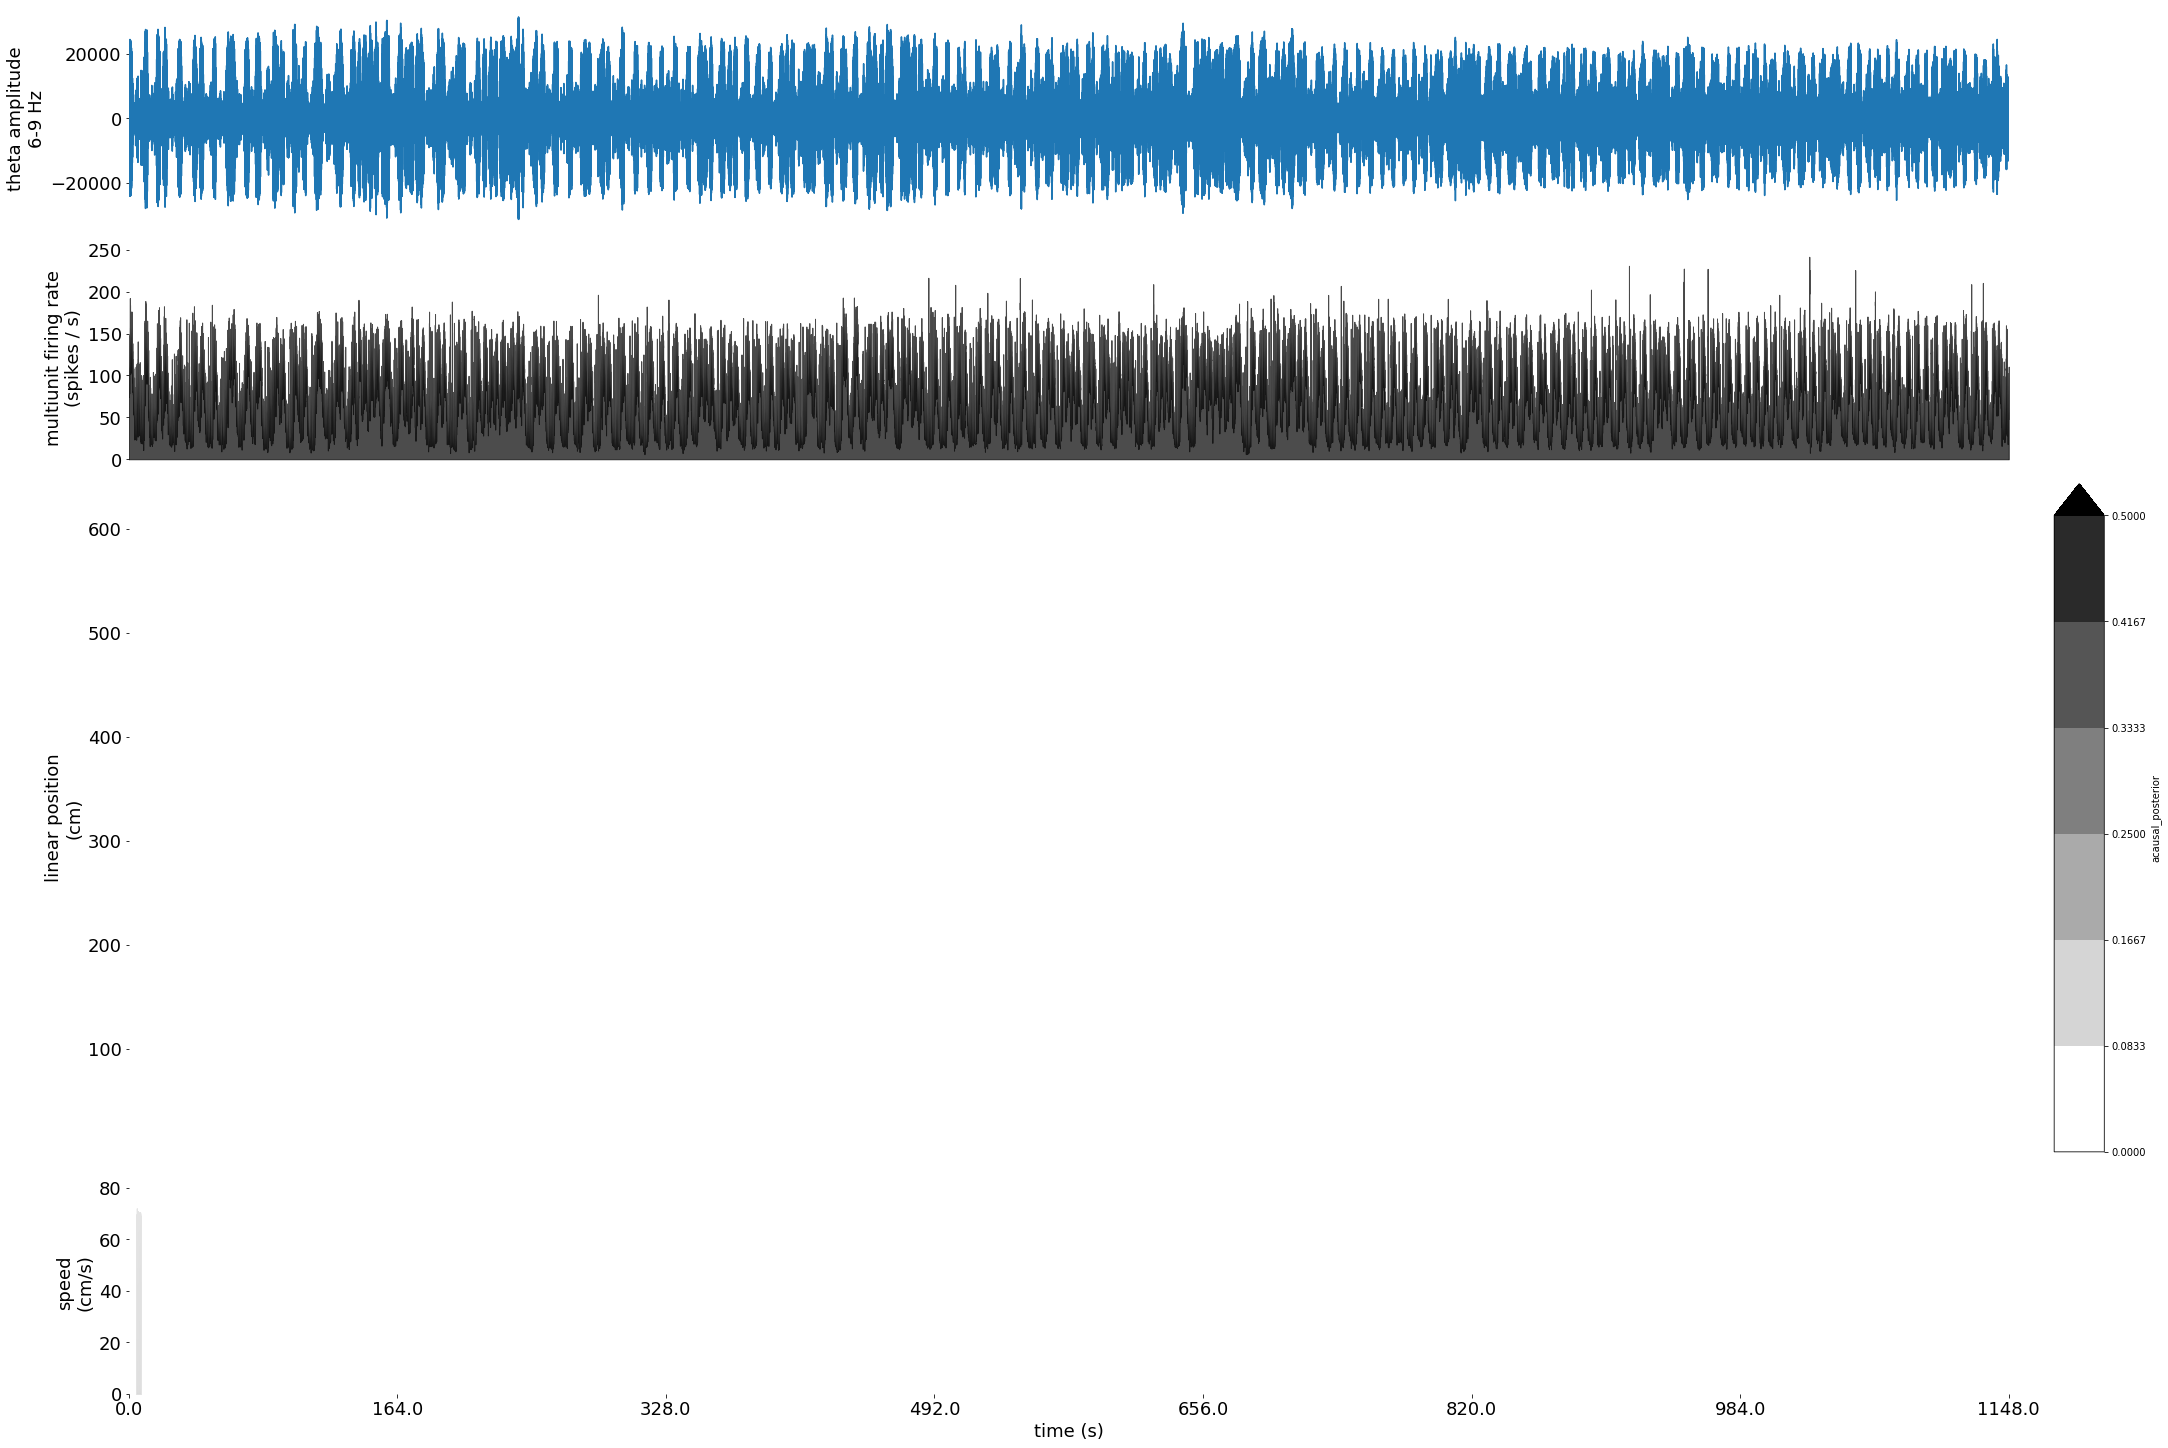

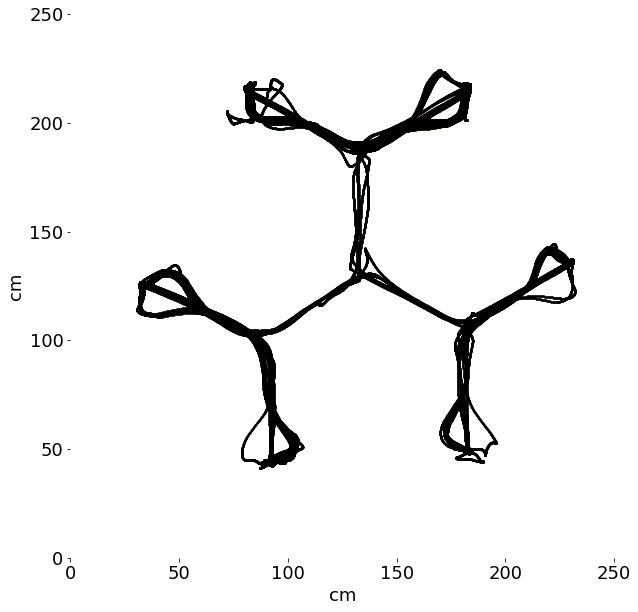

In [84]:
# AC combine CW plots into one figure with subplots
colorthick = 73.25
topcolor=650
botcolor=586

#figure setup
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (30,20), sharex = True, constrained_layout=True, gridspec_kw = {"height_ratios":[1,1,3,1]})

#theta
ax[0].plot(results.time,thetabp_win_ds.values)
ax[0].set_ylabel('theta amplitude\n6-9 Hz',fontsize=18)
ax[0].tick_params(axis='y', labelsize=18)
ax[0].set_xticklabels([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# #mua
ax[1].fill_between(results.time, data['multiunit_firing_rate'][t1:t2].firing_rate,color="black", linewidth=1, alpha=.7)
ax[1].set_ylabel('multiunit firing rate\n(spikes / s)',fontsize=18)
ax[1].tick_params(axis='y', labelsize=18)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

#decode
#results.acausal_posterior.plot.contourf(x='time', y='position', ax=ax[2],cmap=plt.cm.viridis, vmax=.5)
results.acausal_posterior.plot.contourf(x='time', y='position', ax=ax[2], cmap='binary',vmax=.5)
#ax[2].scatter(results.time, data['position_info'][t1:t2].linear_position,c='red',s=.5, alpha = .2)
#for x, color in enumerate(['tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:gray', 'tab:olive', 'tab:red', 'tab:brown', 'tab:pink'], start=0):
#    ax[2].fill([0,t2-t1,t2-t1,0], [botcolor-(x*colorthick),botcolor-(x*colorthick),topcolor-(x*colorthick),topcolor-(x*colorthick)], color=color, alpha=0.15)
#ax[2].set_xlim(0,t2-t1)
ax[2].set_ylabel('linear position\n(cm)',fontsize=18)
ax[2].xaxis.label.set_visible(False)
ax[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False, labelsize=18)
ax[2].tick_params(axis='y', labelsize=18)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)

#speed
ax[3].fill_between(results.time, data['position_info'][t1:t2].speed,color="lightgrey", linewidth=1, alpha=0.6)
ax[3].set_ylabel('speed\n(cm/s)',fontsize=18)
ax[3].set_xlabel('time (s)',fontsize=18);
ax[3].set_ylim(0,max(data['position_info'][t1:t2].speed)*1.2)
ax[3].autoscale(enable=True, axis='x', tight=True)
labels = np.arange(0, ceil(time_stop-time_start), ceil(time_stop-time_start)/8)
plt.xticks(arange(0, t2-t1, (t2-t1)/8), labels, fontsize=18)
ax[3].tick_params(axis='y', labelsize=18)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False)

#2d linpos in SEPARATE figure without shared x
fig, ax = plt.subplots(figsize=(10, 10))
for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=.5, alpha=0.4, label=edge_label)
plt.axis('square')
plt.scatter(data['position_info'][t1:t2].x_position, data['position_info'][t1:t2].y_position, color='k',s=.5)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('cm', fontsize = 18);
plt.ylabel('cm', fontsize = 18);
plt.xticks(fontsize = 18);
plt.yticks(fontsize = 18);
plt.ylim([0,250]);
plt.xlim([0,250]);


# if savefigs==1:
#     plt.savefig(fig_path + 'speed_' + str(t1) + '_' + str(t2) + '.png', format='png',bbox_inches = "tight")


#WHY DOES THE TEMPORAL OR SPATIAL RESOLUTION OF THE DECODE LOOK SO SAD???

time start 2360.420276794 time_stop 3671.662276794 [   0.  164.  328.  492.  656.  820.  984. 1148.]


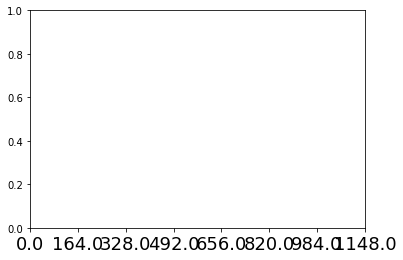

In [82]:
labels = np.arange(0, ceil(time_stop-time_start), ceil(time_stop-time_start)/8)
plt.xticks(arange(0, t2-t1, (t2-t1)/8), labels, fontsize=18)
print('time start', time_start, "time_stop", time_stop, labels)



In [80]:
time_start

2360.420276794

In [81]:
time_stop

3671.662276794

In [78]:
(data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[-1]

3671.662276794

In [85]:
#TIMESLICE ATTEMPT AT FIGURES!!!!
#results.time, data['position_info'][t1:t2].linear_position
#the reason this is confusing is that RESULTS is just the decoded time chunk, 12000 long
#while data is from the whole epoch so you can use a slice on it to get to just [t1:t2], 12000 long as well
#but lets say i just wanted a little bit of the decoded time chunk though
#now from the decode i could just do 0 to a fifth of the length
#but for the data id have to add that to t1 i think?

#t1 and t2 are set above and describe the decode start and stop times
#now say start and stop time in terms of 0 to (t2-t1), with t1=28000 and t2=40000, t2-t1 = 12000

#make start ind and stop ind in results indices units, then can just add that to t1 to get it in data units
plot_start_ind = 0
plot_stop_ind = 12000

#use for results.time[results_time_slice] OR thetabp_win_ds[]
#results.time (t1-t2 in length), results.acausal_posterior, results.likelihood, results.causal_posterior
#NOT results.position? (129 pos bins)
results_time_slice = slice(plot_start_ind,plot_stop_ind)

#use for data[''][data_time_slice].speed
#position_info (x_position, y_position, linear_position, speed), multiunits (time, features/chans, tetrodes), & multiunit_firing_rate (firing_rate)
#NOT theta b/c this theta is at 3x samp rate (bandpassed_lfp, instantaneous_phase, envelope_magnitude)
data_time_slice = slice(plot_start_ind + t1, plot_stop_ind + t1)

#when calculating theta new timestamps, CW also made the min and max times which i guess doesn't really make sense to only do once, that's what i want to do again
#time_start = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[0] # sec
#time_stop = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[-1]
time_start = (data['position_info'][data_time_slice].index / np.timedelta64(1, 's'))[0] # sec
time_stop = (data['position_info'][data_time_slice].index / np.timedelta64(1, 's'))[-1]

#then the actual time labeling we want in seconds SINCE EPOCH start, not set to 0 for now, so that would be
print(results_time_slice, data_time_slice, time_start, time_stop)

slice(0, 12000, None) slice(0, 12000, None) 2360.420276794 2384.418276794


In [59]:
# data['multiunit_firing_rate'][data_time_slice].firing_rate

In [60]:
# len(thetabp_win_ds[results_time_slice].values)

In [86]:
int(results.time[results_time_slice.start])

2360

In [87]:
#np.arange(np.round(time_start,2), np.round(time_stop,2), np.round((time_stop-time_start)/8,2))

In [88]:
#arange(np.round(time_start,2), np.round(time_stop,2), (np.round(time_stop,2)-np.round(time_start,2))/8)

In [89]:
#results.time[results_time_slice]

2360.420276794 2480.418276794
AxesSubplot(0.125,0.251615;0.64325x0.375155)


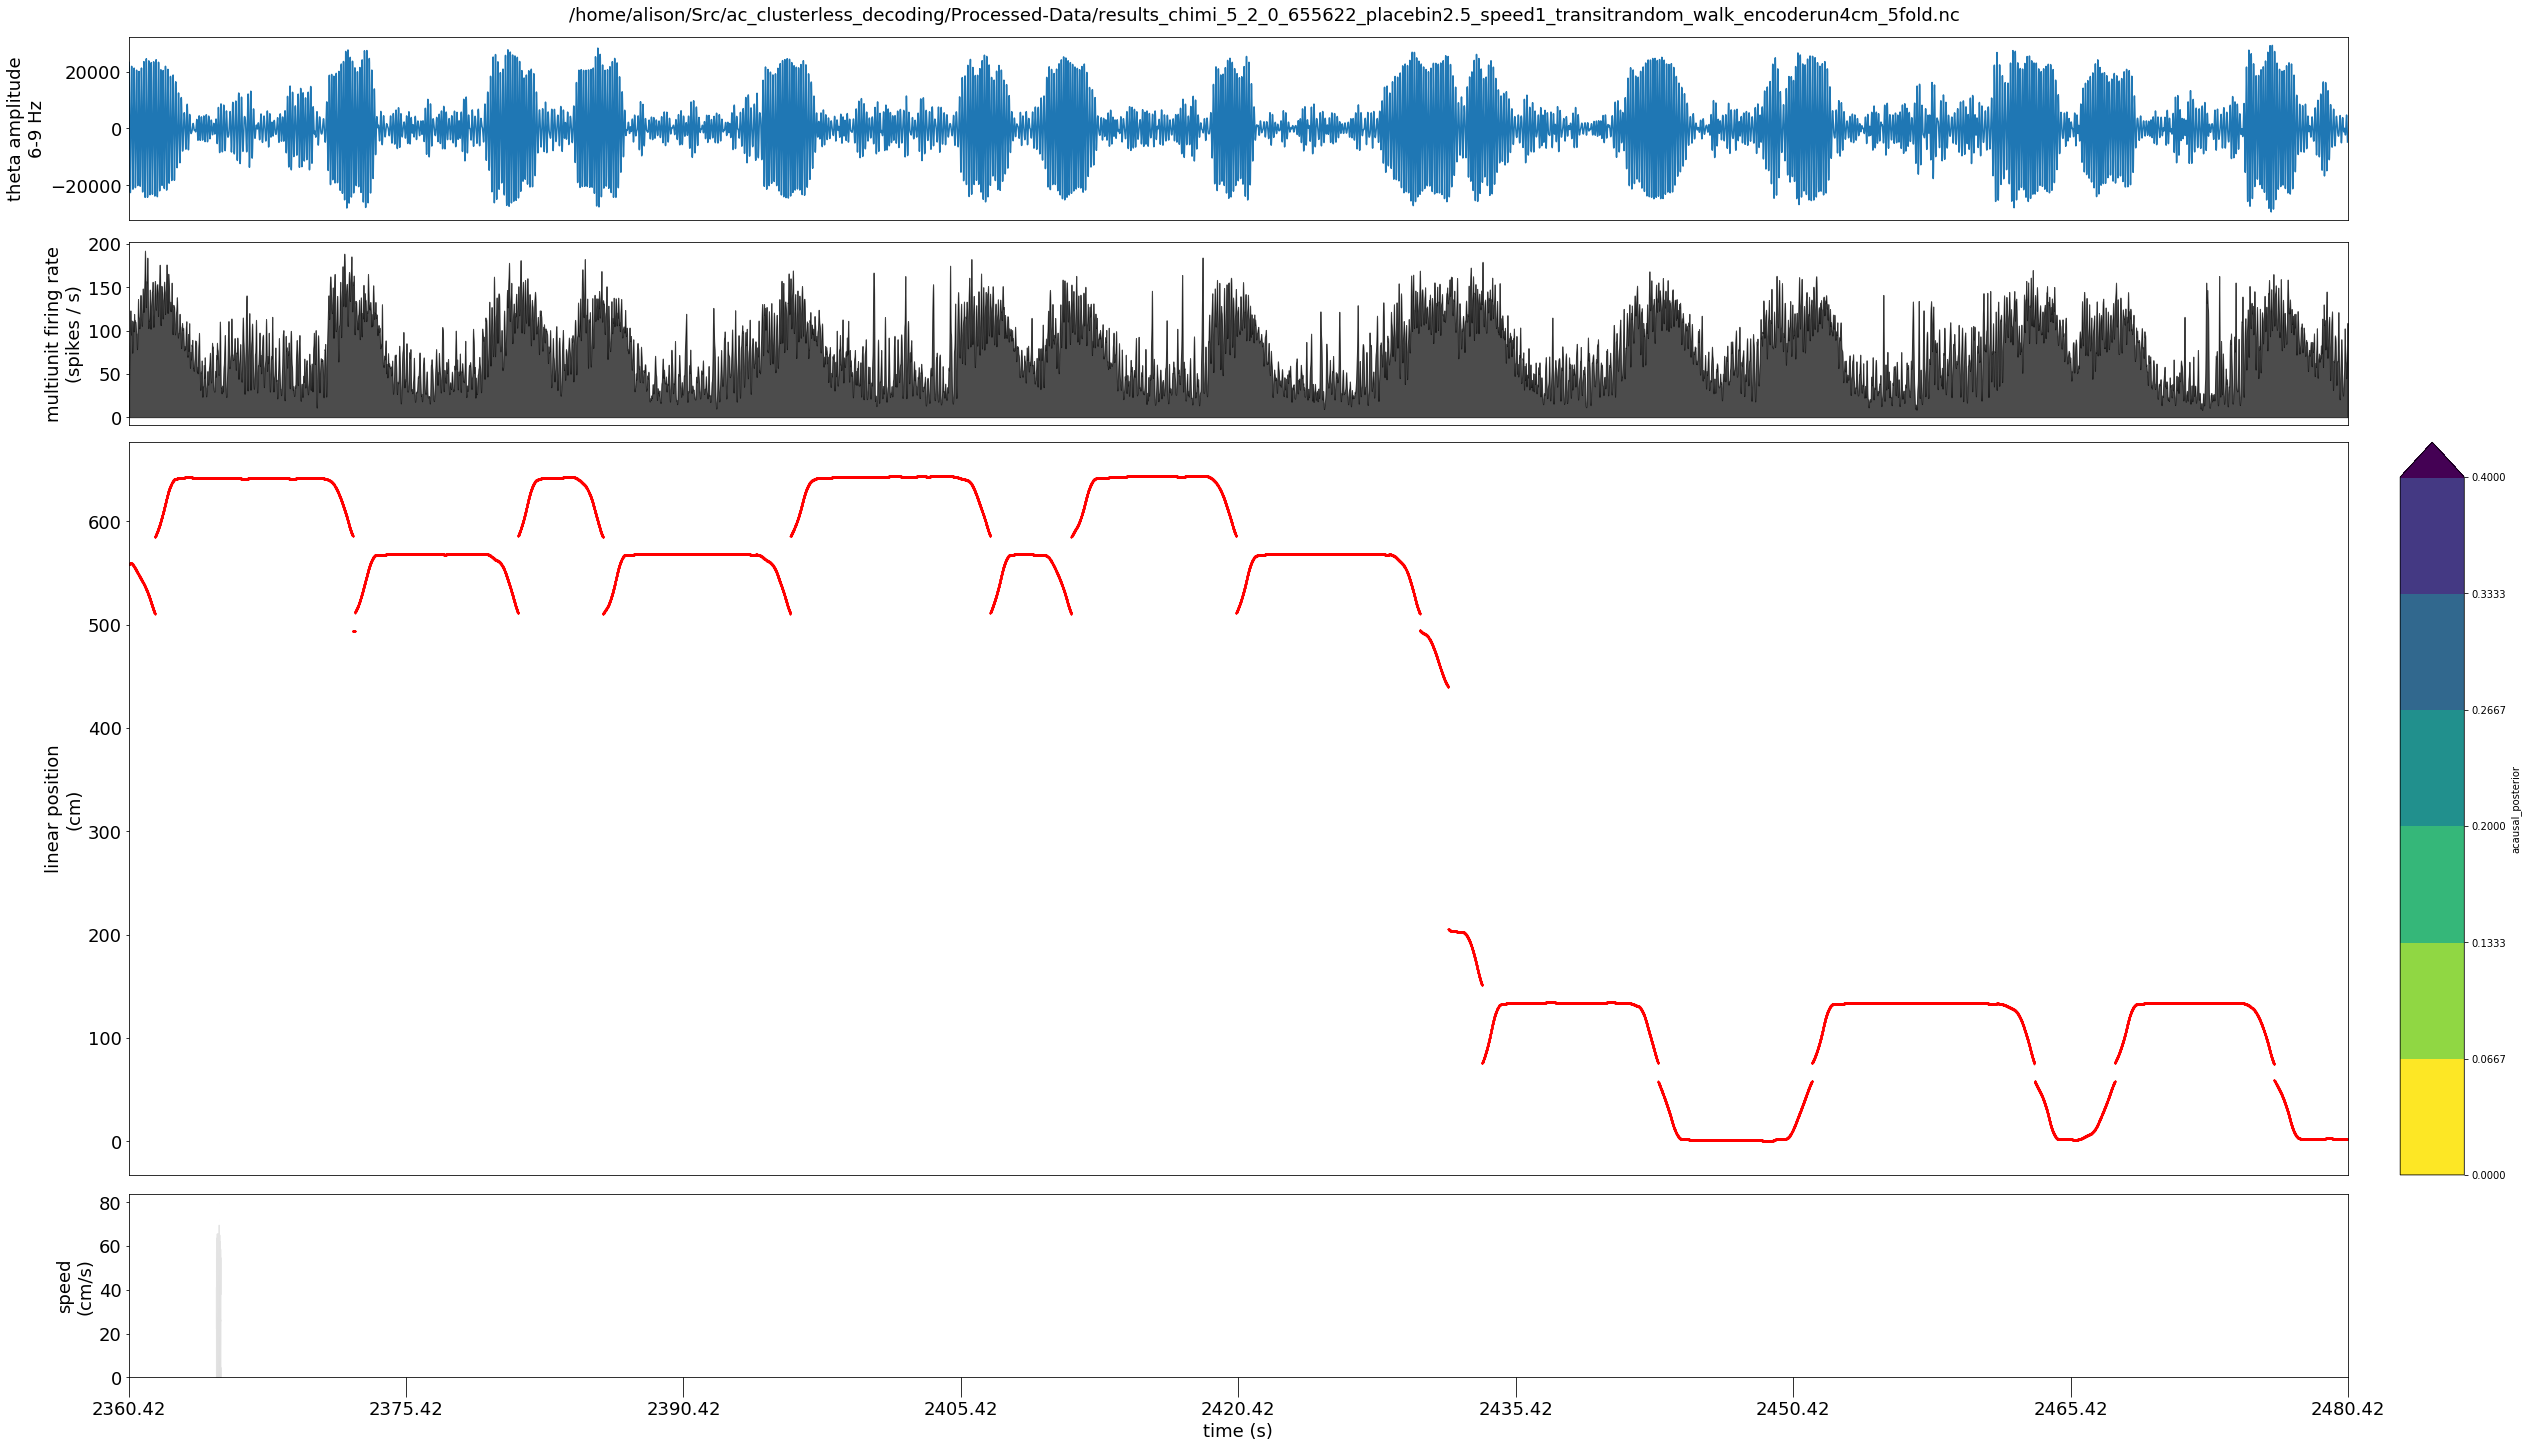

In [90]:
#make start ind and stop ind in results indices units, then can just add that to t1 to get it in data units
plot_start_ind = 0
plot_stop_ind = 60000
#use for results.time[results_time_slice] OR thetabp_win_ds[]
results_time_slice = slice(plot_start_ind,plot_stop_ind)
#use for data[''][data_time_slice].speed
data_time_slice = slice(plot_start_ind + t1, plot_stop_ind + t1)
#when calculating theta new timestamps, CW also made the min and max times which i guess doesn't really make sense to only do once, that's what i want to do again
time_start = (data['position_info'][data_time_slice].index / np.timedelta64(1, 's'))[0] # sec
time_stop = (data['position_info'][data_time_slice].index / np.timedelta64(1, 's'))[-1]
print(time_start, time_stop)

# AC combine CW plots into one figure with subplots - now try to get a specific time slice!!!!! rather than showing all of t1 to t2
colorthick = 73.25
topcolor=650
botcolor=586

#figure setup
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (35,20), sharex = True, constrained_layout=True, gridspec_kw = {"height_ratios":[1,1,4,1]})
plt.suptitle(results_path, fontsize=18)

#theta
ax[0].plot(results.time[results_time_slice],thetabp_win_ds[results_time_slice].values)
ax[0].set_ylabel('theta amplitude\n6-9 Hz',fontsize=18)
ax[0].tick_params(axis='y', labelsize=18)
ax[0].set_xticklabels([])

#mua
ax[1].fill_between(results.time[results_time_slice], data['multiunit_firing_rate'][data_time_slice].firing_rate,color="black", linewidth=1, alpha=.7)
ax[1].set_ylabel('multiunit firing rate\n(spikes / s)', fontsize=18)
ax[1].tick_params(axis='y', labelsize=18)

#decode
results.acausal_posterior[results_time_slice].plot.contourf(x='time', y='position', ax=ax[2],cmap=plt.cm.viridis_r, vmin=0, vmax=.4)
#results.acausal_posterior[results_time_slice].plot.contourf(x='time', y='position', ax=ax[2], cmap='binary',vmin=0,vmax=1)
ax[2].scatter(results.time[results_time_slice], data['position_info'][data_time_slice].linear_position,c='red',s=.5, alpha = 1)
#ax[2].set_xlim(time_start,time_stop-1)
#for x, color in enumerate(['tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:gray', 'tab:olive', 'tab:red', 'tab:brown', 'tab:pink'], start=0):
#    ax[2].fill(results.time[results_time_slice.start],results.time[results_time_slice.stop-1],results.time[results_time_slice.stop-1],results.time[results_time_slice.start], [botcolor-(x*colorthick),botcolor-(x*colorthick),topcolor-(x*colorthick),topcolor-(x*colorthick)], color=color, alpha=0.15)
#ax[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False, labelsize=18)
ax[2].tick_params(axis='y', labelsize=18)
ax[2].set_ylabel('linear position\n(cm)',fontsize=18)
ax[2].xaxis.label.set_visible(False)
print(ax[2].axes)

#speed
ax[3].fill_between(results.time[results_time_slice], data['position_info'][data_time_slice].speed,color="lightgrey", linewidth=1, alpha=0.6)
ax[3].set_ylabel('speed\n(cm/s)',fontsize=18)
ax[3].set_xlabel('time (s)',fontsize=18);
ax[3].set_ylim(0,max(data['position_info'][data_time_slice].speed)*1.2)
ax[3].autoscale(enable=True, axis='x', tight=True)
ax[3].tick_params(axis='y', labelsize=18)
ax[3].set_xticks(np.round(np.linspace(plot_start_ind, plot_stop_ind, num=9, endpoint=True)))
ax[3].set_xticklabels(np.round(np.linspace(time_start, time_stop, num=9, endpoint=True),2))
ax[3].tick_params(axis='x', labelsize=18, length=20)


In [24]:
#timeslice expts^^

In [25]:
time_slice=slice(data['multiunits'].time[t1],data['multiunits'].time[t2-1])
#data['multiunits']
time_slice

slice(<xarray.DataArray 'time' ()>
array(3080420276794, dtype='timedelta64[ns]')
Coordinates:
    time     timedelta64[ns] 00:51:20.420276, <xarray.DataArray 'time' ()>
array(3200418276794, dtype='timedelta64[ns]')
Coordinates:
    time     timedelta64[ns] 00:53:20.418276, None)

In [26]:
data['multiunits'].sel(time=time_slice).time / np.timedelta64(1, 's')

<xarray.DataArray 'time' (time: 60000)>
array([3080.42027679, 3080.42227679, 3080.42427679, ..., 3200.41427679,
       3200.41627679, 3200.41827679])
Coordinates:
  * time     (time) timedelta64[ns] 00:51:20.420276 ... 00:53:20.418276

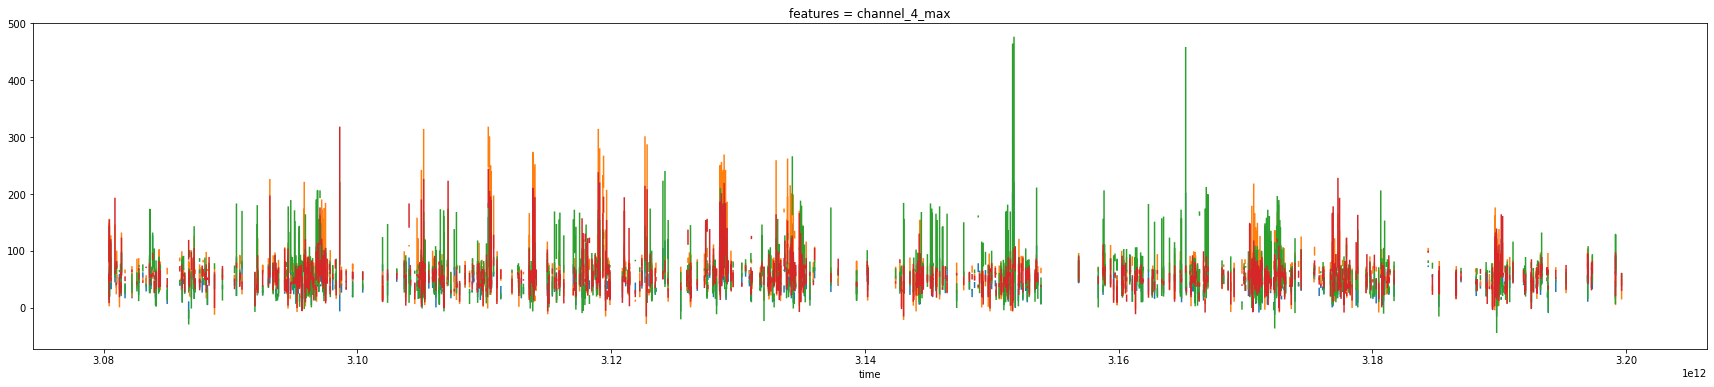

In [27]:
data['multiunits'][:,0,0].sel(time=time_slice).plot(figsize=(30,6))  
data['multiunits'][:,1,0].sel(time=time_slice).plot()  
data['multiunits'][:,2,0].sel(time=time_slice).plot()  
data['multiunits'][:,3,0].sel(time=time_slice).plot()  
#all times in slice, channel 1, tetrode 1

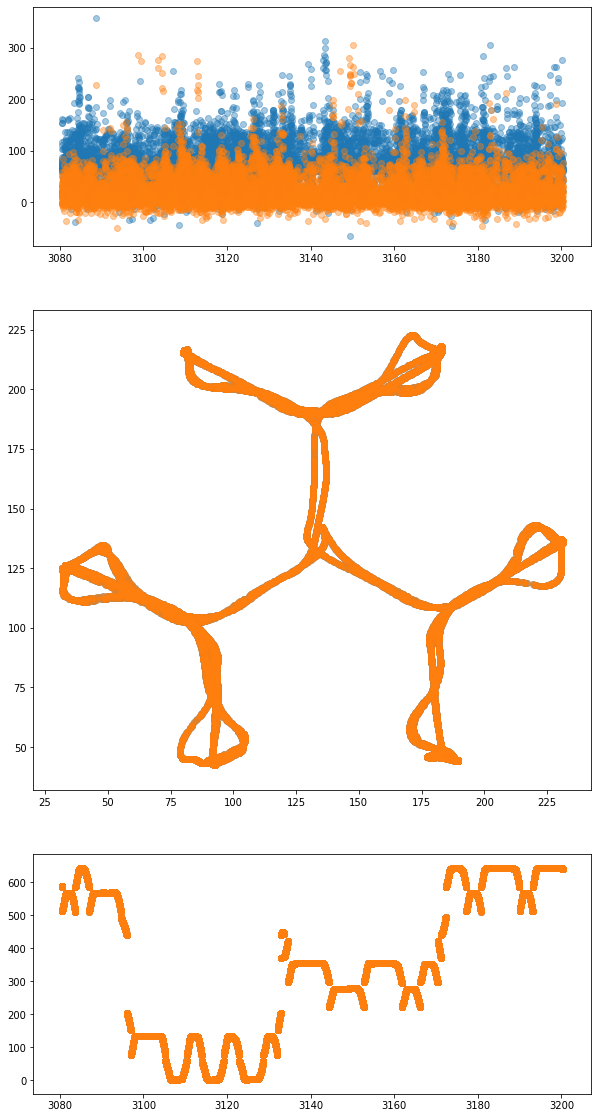

In [28]:
tet=5
time_slice=slice(data['multiunits'].time[t1],data['multiunits'].time[t2])


fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,20),gridspec_kw = {"height_ratios":[1,2,1]})
for chan in [0,3]:
    spikesbool = ~np.isnan(data['multiunits'][:,chan,tet].sel(time=time_slice)) #or > 150
    #spikesbool = data['multiunits'][:,chan,tet].sel(time=time_slice) > 100
    spikestimes = spikesbool[spikesbool==True].time.values
    #print(spikestimes)
    #ampl_size=data['multiunits'][:,chan,tet].sel(time=time_slice).mean()
    ax[0].scatter(data['multiunits'][:,chan,tet].sel(time=time_slice).time/np.timedelta64(1,'s'),
            data['multiunits'][:,chan,tet].sel(time=time_slice), alpha=0.4)
    ax[1].scatter(data['position_info']['x_position'][spikestimes],data['position_info']['y_position'][spikestimes],alpha=0.5) #,s=ampl_size,alpha=0.2)
    #print(data['position_info']['linear_position'][spikestimes].index / np.timedelta64(1,'s'))
    ax[2].scatter(data['position_info']['linear_position'][spikestimes].index / np.timedelta64(1,'s'),data['position_info']['linear_position'][spikestimes])

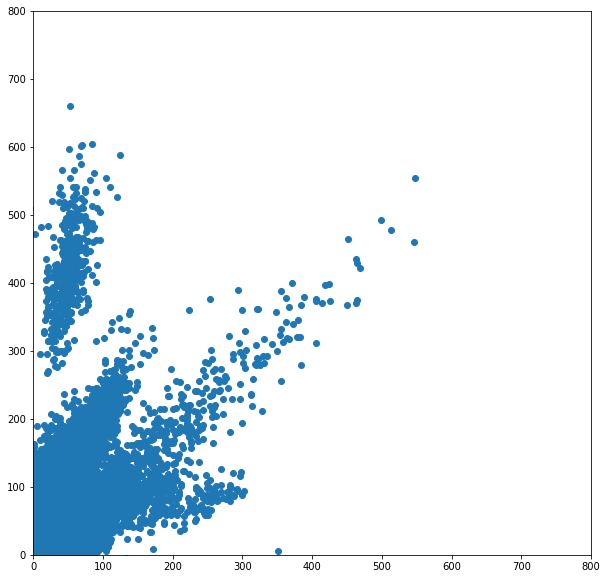

In [29]:
tet=5
chans = [1,2]
plt.figure(figsize=(10,10))
plt.scatter(data['multiunits'][:,chans[0],5],data['multiunits'][:,chans[1],tet])
plt.xlim(0,800)
plt.ylim(0,800)
plt.show()

In [30]:
#set up decoder again so can access place bin info?
#have some of the params defined from reading in data 

In [31]:
from replay_trajectory_classification import ClusterlessDecoder
decoder = ClusterlessDecoder(transition_type=transition_type, replay_speed=replay_speed, movement_var=6, place_bin_size=place_bin_size)

In [32]:
## MOVIE?? ##

from src.visualization import plot_2D_position_with_color_time, make_movie
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection
from loren_frank_data_processing.track_segment_classification import get_track_segments_from_graph, project_points_to_segment
from src.parameters import SAMPLING_FREQUENCY




In [33]:
frame_rate = SAMPLING_FREQUENCY / 4
time = results.time.values #time = cv_classifier_clusterless_results.time.values
time_slice = results_time_slice #slice(time[t1], time[t2])

In [34]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [35]:
from src.parameters import EDGE_ORDER, EDGE_SPACING

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

In [36]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=6,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=2.5, position_range=None, replay_speed=1,
                   transition_type='random_walk')

In [37]:
place_bin_centers = decoder.place_bin_centers_.copy() #cv_classifier.place_bin_centers_.copy()

In [38]:
for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

In [39]:
place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

In [40]:
t = data["position_info"].index / np.timedelta64(1, "s")

In [41]:
#map_position_ind = (
#    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
#)

map_position_ind = (
    results.sel(time=time_slice).acausal_posterior.argmax("position").values
)

map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

In [42]:
track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

In [43]:
projected_track_positions


array([[ 89.99080625, 211.12769686],
       [ 89.95423347, 211.14798552],
       [ 89.9176607 , 211.16827418],
       ...,
       [175.48840721, 212.95121403],
       [175.48880062, 212.95144166],
       [175.48919404, 212.9516693 ]])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep_testing.mp4']
INFO:root:Done


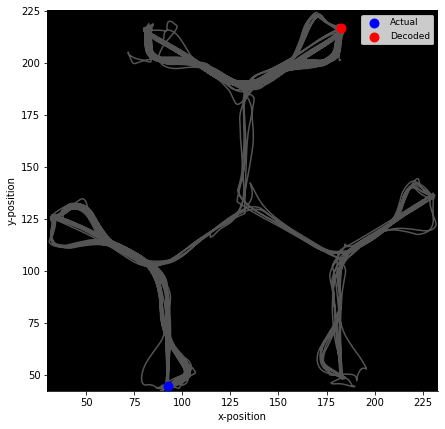

In [38]:
# 16 seconds
make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep_testing.mp4")
logging.info('Done')